In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import datetime
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

%load_ext tensorboard

In [ ]:
# Install package Kaggle for dataset download
! pip install kaggle -q

#Download and unzip Kaggle dataset

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download yuweisunut/sidd-segmented-intrusion-detection-dataset
!unzip sidd-segmented-intrusion-detection-dataset

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/463.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/464.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/465.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/466.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/467.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/468.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/469.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/47.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/470.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/471.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/472.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/473.jpg  
  inflating: SIDD/n056

In [ ]:
directory = 'SIDD'

imgs = {}
uid = 0
label_counts = {0: 0, 1: 0}

for client in os.listdir(directory):
    curr_path = f'{directory}/{client}/pcap'

    for subdir in os.listdir(curr_path):
        curr_path = f'{directory}/{client}/pcap/{subdir}/dataset'
        curr_type = subdir[-1:]
        if curr_type == str(1):
            for dayscen in os.listdir(curr_path):
                curr_path = f'{directory}/{client}/pcap/{subdir}/dataset/{dayscen}'
                for i, img in enumerate(os.listdir(curr_path)):
                    if i == 45:
                       break
                    if dayscen == 'benign':
                        label = 0
                    elif dayscen == 'malicious':
                        label = 1
                    imgs[uid] = {'id': uid, 'label': str(label), 'fn': img, 'path': curr_path + '/' + img}
                    uid += 1
                    label_counts[label] += 1
                    
print(label_counts)
print(label_counts[1] / label_counts[0] * 100)

total = label_counts[1] + label_counts[0]
neg = label_counts[0]
pos = label_counts[1]

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


{0: 46493, 1: 6501}
13.98275009141161
Weight for class 0: 0.57
Weight for class 1: 4.08


In [ ]:
img_df = pd.DataFrame.from_dict(imgs,orient='index')
img_df['label'] = img_df['label'].astype(int)
print(len(img_df))

52994


In [ ]:
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=1)
    image = tf.cast(image_decoded, tf.float32)
    image /= 255.0
    label = tf.reshape(label, [1])
    return image, label

file_paths = img_df.path
file_labels = img_df["label"].values.reshape(-1, 1)

dataset = tf.data.Dataset.from_tensor_slices((file_paths, file_labels))
prefetch_size = tf.data.AUTOTUNE
dataset = dataset.map(_parse_function)
dataset = dataset.batch(512)
dataset = dataset.prefetch(prefetch_size)
dataset = dataset.shuffle(10000)
dataset.element_spec

(TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))

In [ ]:
def get_dataset_partitions_tf(ds, ds_size, train_split, val_split, test_split):
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    print('Size of {}:  {}'.format('train ds', str(train_ds.cardinality().numpy())))
    print('Size of {}:  {}'.format('val ds', str(val_ds.cardinality().numpy())))
    print('Size of {}:  {}'.format('test ds', str(test_ds.cardinality().numpy())))
    
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds=dataset, ds_size=dataset.cardinality().numpy(), train_split=0.8, val_split=0.1, test_split=0.1)

Size of train ds:  83
Size of val ds:  10
Size of test ds:  11


In [ ]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    # Calculate F1 score
    f1_score = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

    return f1_score

In [ ]:
height = 48
width = 48
channels = 1

input_shape = (height, width, channels)

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
    
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 50)                1

In [ ]:
history = model.fit(
    x=train_ds,
    epochs=70,
    validation_data=val_ds
)

loss, precision, recall, binaryAcc, truePos, trueNeg, falNeg, falPos = model.evaluate(test_ds)

Epoch 1/70
83/83 [==============================] - 2s 15ms/step - loss: 0.1005 - precision: 0.8283 - recall: 0.8140 - binary_accuracy: 0.9554 - true_positives: 4345.0000 - true_negatives: 36257.0000 - false_negatives: 993.0000 - false_positives: 901.0000 - val_loss: 0.1421 - val_precision: 0.8506 - val_recall: 0.8119 - val_binary_accuracy: 0.9361 - val_true_positives: 803.0000 - val_true_negatives: 3990.0000 - val_false_negatives: 186.0000 - val_false_positives: 141.0000
Epoch 2/70
83/83 [==============================] - 2s 14ms/step - loss: 0.0950 - precision: 0.8342 - recall: 0.8040 - binary_accuracy: 0.9591 - true_positives: 3905.0000 - true_negatives: 36609.0000 - false_negatives: 952.0000 - false_positives: 776.0000 - val_loss: 0.0965 - val_precision: 0.8577 - val_recall: 0.8685 - val_binary_accuracy: 0.9574 - val_true_positives: 687.0000 - val_true_negatives: 4215.0000 - val_false_negatives: 104.0000 - val_false_positives: 114.0000
Epoch 3/70
83/83 [============================

In [ ]:
%tensorboard --logdir logs/fit/

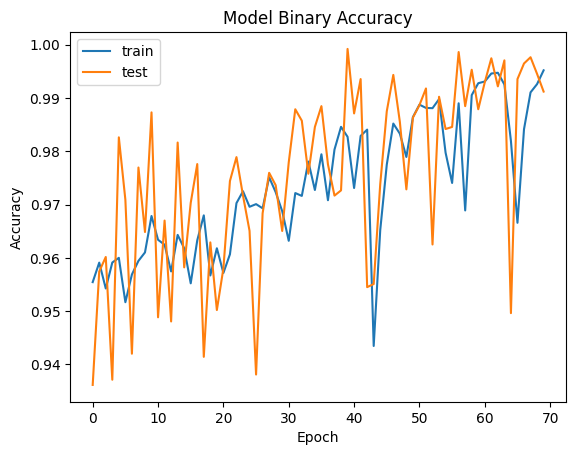

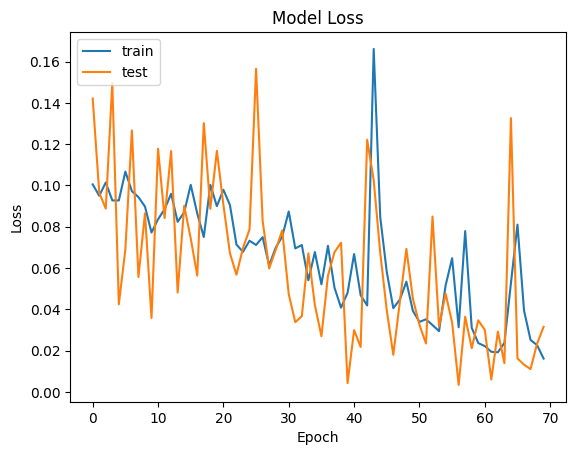

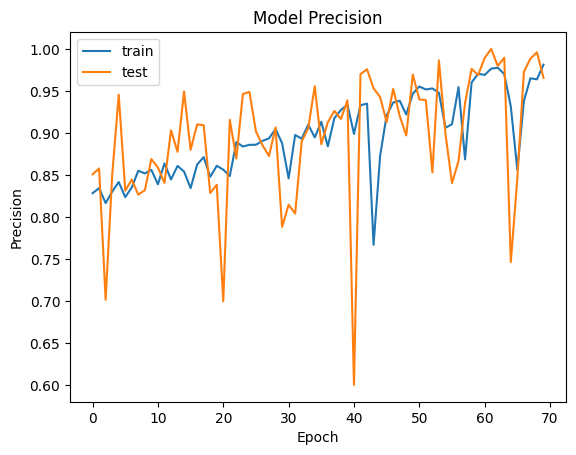

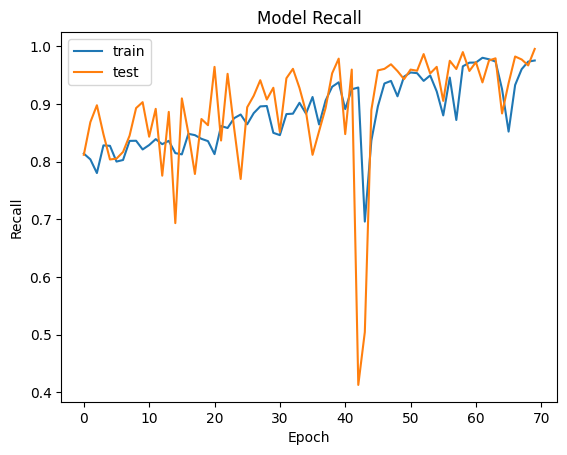

KeyError: ignored

In [ ]:
#Plot accuracy of model
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Binary Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plot loss of model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plot precision of model
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plot recall of model
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plot f1_score of model
"""
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
"""